In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
from PIL import Image, ImageDraw, ImageFont
from datetime import datetime
from math import ceil, floor
from skimage.util import montage
from sklearn.metrics import confusion_matrix
from tensorboardX import SummaryWriter
from torch.autograd import Variable
from torchvision.transforms import Compose
from typing import *
import copy 
import cv2
import glob
import inspect
import itertools
import json
import math
import matplotlib.pyplot as plt 
import multiprocessing
import numpy as np
import os
import pandas as pd
import pathlib
import pickle
import random 
import scipy
import sklearn
import socket
import string
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.init as init
import torch.optim as optim

### Read and process the data

In [3]:
from src import data_prep, dataset, train

In [4]:
df = data_prep.get_df_from_folder('/home/anuj/code/data/lfw_train')
df_train, df_val = data_prep.split_train_val(df)

In [5]:
np.sum(df_train.groupby('label').count() > 1), np.sum(df_val.groupby('label').count() > 1)

(idx     1356
 path    1356
 dtype: int64, idx     340
 path    340
 dtype: int64)

In [6]:
dataset_train, dataloader_train = dataset.get_dataloader(df_train, batch_size=2*24)
dataset_val, dataloader_val = dataset.get_dataloader(df_val, batch_size=2*24)

Training: 327,846 total positive pairs 6,831 mini batches
Training: 15,200 total positive pairs 317 mini batches


### Visualize some

In [7]:
from src import visualize

tensor([1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0.,
        1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0.,
        1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0.,
        1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0.,
        1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0.,
        1., 0., 1., 0., 1., 0.])


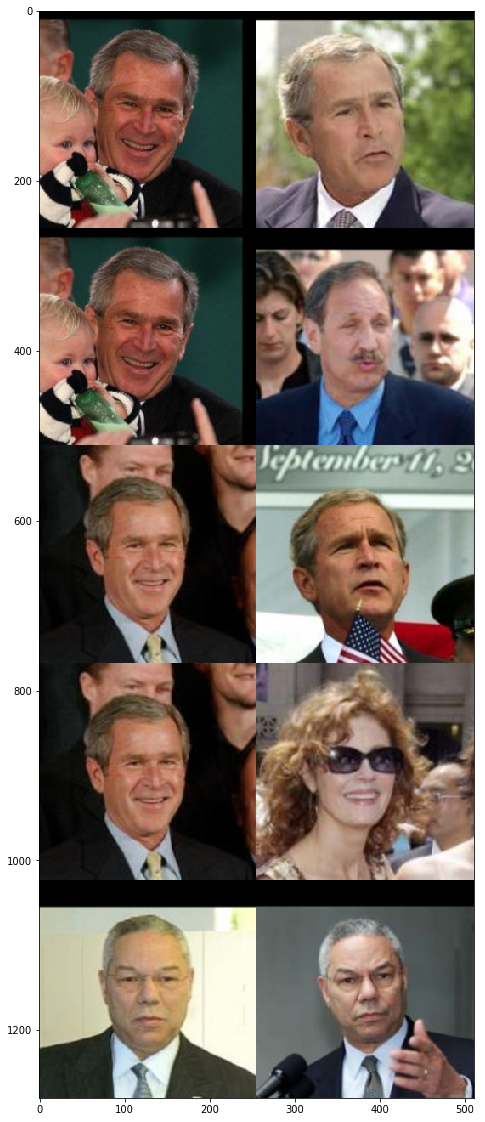

tensor([1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0.,
        1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0.,
        1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0.,
        1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0.,
        1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0.,
        1., 0., 1., 0., 1., 0.])


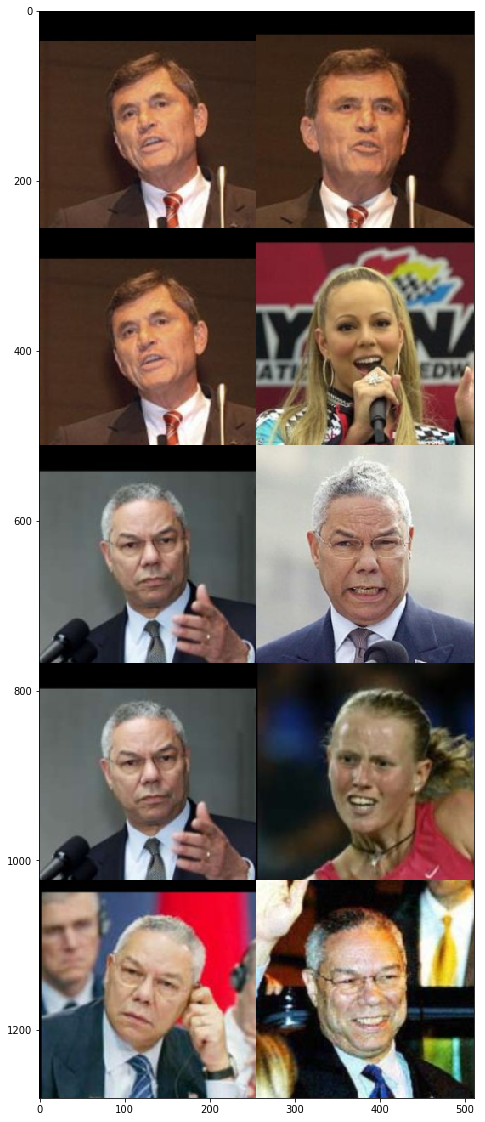

In [8]:
for ix, batch in enumerate(dataloader_val):
    if ix >= 2:
        break
    visualize.visualize(batch, 5)

### Model, Optimizer, Loss

In [9]:
from src.models import segnet
from src.loss import ContrastiveLoss

In [10]:
device_id = 2

In [11]:
model = segnet.SiameseNetworkLarge(256)
model = torch.nn.DataParallel(model, device_ids=[2, 3]).cuda(device_id)

# loss_func = torch.nn.NLLLoss(weight=None).cuda(device_id)
optimizer = torch.optim.Adam(model.parameters())

In [12]:
loss_func = ContrastiveLoss().cuda(device_id)

### Setup loggging

In [13]:
model_str = 'face-siamese-contrastive-2.04'
weights_folder = f"/home/anuj/weights/{model_str}"
writer = SummaryWriter(weights_folder) # writing log to tensorboard
print('logging to: {}'.format(weights_folder))

logging to: /home/anuj/weights/face-siamese-contrastive-2.04


### Train

In [14]:
def run_training_loop(iter_start=0, max_epochs=100, val_every=50, save_every=500):
    iter_cntr = iter_start
    model.train(True)

    try:
        while True:
            for batch in dataloader_train:
                iter_cntr += 1

                error_train = train.train_iter(
                    batch=batch,
                    model=model,
                    optimizer=optimizer,
                    loss_func=loss_func,
                    device=device_id
                )

                writer.add_scalar('train.loss', error_train, iter_cntr)

                if iter_cntr%val_every==0:
                    error_val, cm = train.evaluate(
                        dataloader_val, model=model, loss=loss_func, device=device_id, n_iters=2
                    )
                    writer.add_scalar('val.loss', error_val, iter_cntr)
#                     print(cm)

                if iter_cntr%save_every==0:
                    torch.save(model.state_dict(), "%s/feat-%d.pt"%(weights_folder,iter_cntr))

    except KeyboardInterrupt:
        torch.save(model.state_dict(), "%s/feat-%d.pt"%(weights_folder,iter_cntr))

In [15]:
model_str

'face-siamese-contrastive-2.04'

In [16]:
model.load_state_dict(torch.load('/home/anuj/weights/face-siamese-contrastive-2.04/feat-5000.pt'))

IncompatibleKeys(missing_keys=[], unexpected_keys=[])

In [ ]:
run_training_loop(iter_start=5200)